## 3 Channel, CNN, Only Sun

In [1]:
# Math
import numpy as np
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import StepLR
# Custom
from loader import  IlluminationModule_SUN, Train_Dataset_SUN, Eval_Dataset_SUN
import os
from libs.projections import bin2Sphere
from utils import getAngle

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
BATCH_SIZE = 64
EPOCHS = 500

# 하이퍼파라미터 설정
learning_rate = 0.01

In [4]:
dataset = Train_Dataset_SUN(csv_path='./mydata/trans_mode_label.csv')
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [5]:
eval_dataset = Eval_Dataset_SUN(csv_path='./mydata/trans_mode_label.csv')
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [6]:
illuminationModule = IlluminationModule_SUN().cuda()

In [7]:
from torchsummary import summary

summary(illuminationModule, input_size=(3,320,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 120]           9,472
       BatchNorm2d-2         [-1, 64, 160, 120]             128
               ELU-3         [-1, 64, 160, 120]               0
            Conv2d-4          [-1, 128, 80, 60]         204,928
       BatchNorm2d-5          [-1, 128, 80, 60]             256
               ELU-6          [-1, 128, 80, 60]               0
            Conv2d-7          [-1, 256, 40, 30]         295,168
       BatchNorm2d-8          [-1, 256, 40, 30]             512
               ELU-9          [-1, 256, 40, 30]               0
           Conv2d-10          [-1, 256, 40, 30]         590,080
      BatchNorm2d-11          [-1, 256, 40, 30]             512
              ELU-12          [-1, 256, 40, 30]               0
           Conv2d-13          [-1, 256, 20, 15]         590,080
      BatchNorm2d-14          [-1, 256,

In [8]:
sun_crit = nn.KLDivLoss()
prr_crit = nn.MSELoss()
# set optimizer
optimizer = optim.Adam(illuminationModule.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [9]:
def trainloop(module, lr=0.01, train_epochs=EPOCHS):
    global total_l, sky_l, sun_l
    # set training dataset
    dataset = Train_Dataset_SUN(csv_path='./mydata/trans_mode_label.csv')
    train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

    # using KL divergence loss for sun distribution and MSE loss  
    sun_crit = nn.KLDivLoss()
    # set optimizer
    optimizer = torch.optim.Adam(module.parameters(), lr=lr)

    # train the model
    cur_lr = lr

    for i in range(train_epochs):
        for i_batch, sample in enumerate(train_dataloader):
            # training input and targets
            img = sample['img'].cuda().float()
            label_dis = sample['dis'].cuda().float()

            # forward pass 
            pred_dis = module(img)
            beta = 0.1 # to compensate for the number od bins in output distribution
            loss = sun_crit(pred_dis, label_dis)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_l.append(loss.item())
        
        print('='*20,'EPOCH : ', i,'='*20)
        print('-'*20,'TRAIN','-'*20)
        print("sun_loss : {:.5f} ".format(loss.item()))
        print('-'*20,'TEST','-'*20)
        evaluate(module, eval_dataloader, optimizer, train_epochs)
        
        # Decay learning rate (0.5/15 epochs)
        if i % 15 == 0:
            cur_lr *= 0.5
            update_lr(optimizer, cur_lr)
        

    # Save the model checkpoint
    torch.save(module.state_dict(), '17_sun_weights.pth')

In [10]:
test_total_l = []

def evaluate(module, eval_dataloader, optimizer, epoch):
    # loss function
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()

    # data loader
    eval_dataset = Eval_Dataset_SUN(csv_path='./mydata/trans_mode_label.csv')
    eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=4)

    module.eval()
    
    sum_err = np.asarray([0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    for i, sample in enumerate(eval_dataloader):
        input_img = sample['img'].cuda().float()
        label_dis = sample['dis'].cuda().float()
        sunpos = sample['sp'][0].numpy()

        with torch.no_grad():
            #print("="*20,i,"="*20)
            pred_dis = module(input_img)
            loss = sun_crit(pred_dis, label_dis)

            # calculate all prediction error
            bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
            pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
            #print('pred_sunpos : ', pred_sunpos)
            suns.append(pred_sunpos)
            suns_gt.append(sunpos)
            sunpos_err = getAngle(sunpos, pred_sunpos)
            angular.append(sunpos_err)
            sum_err += np.asarray([sunpos_err])
    print("sun_loss : {:.5f}".format(loss.item()))
    test_total_l.append(loss.item())
    # print average prediction errors across all testing dataset
    if epoch == 499:    
        print("="*20,"FINAL ERROR","="*20)
        print('Testing avg loss:', sum_loss/data_length)
        final_err = sum_err/data_length
        print('Average predictions error:')
        print('sun position (angular error):', final_err[0])
    return suns_gt, suns, bins, angular

In [11]:
def main():

    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    Module = IlluminationModule_SUN().cuda()

    trainloop(Module)
    
total_l = []
sun_l = []
sky_l = []

if __name__ == '__main__':
    main()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


==================== EPOCH :  0 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01214 
-------------------- TEST --------------------
sun_loss : 0.08630
==================== EPOCH :  1 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01300 
-------------------- TEST --------------------
sun_loss : 0.00873
==================== EPOCH :  2 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01078 
-------------------- TEST --------------------
sun_loss : 0.00841
==================== EPOCH :  3 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01058 
-------------------- TEST --------------------
sun_loss : 0.00893
==================== EPOCH :  4 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00972 
-------------------- TEST --------------------
sun_loss : 0.00849
==================== EPOCH :  5 ====================
------------

sun_loss : 0.01053
==================== EPOCH :  44 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00007 
-------------------- TEST --------------------
sun_loss : 0.01008
==================== EPOCH :  45 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00007 
-------------------- TEST --------------------
sun_loss : 0.01045
==================== EPOCH :  46 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00007 
-------------------- TEST --------------------
sun_loss : 0.01046
==================== EPOCH :  47 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00007 
-------------------- TEST --------------------
sun_loss : 0.01032
==================== EPOCH :  48 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00006 
-------------------- TEST --------------------
sun_loss : 0.01034
==================== EPOCH :  49 ========

sun_loss : 0.01106
==================== EPOCH :  88 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01107
==================== EPOCH :  89 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01103
==================== EPOCH :  90 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01107
==================== EPOCH :  91 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01110
==================== EPOCH :  92 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01109
==================== EPOCH :  93 ========

sun_loss : 0.01121
==================== EPOCH :  132 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01120
==================== EPOCH :  133 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01121
==================== EPOCH :  134 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01121
==================== EPOCH :  135 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01121
==================== EPOCH :  136 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01120
==================== EPOCH :  137 ==

sun_loss : 0.01122
==================== EPOCH :  176 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01122
==================== EPOCH :  177 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01122
==================== EPOCH :  178 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01122
==================== EPOCH :  179 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01122
==================== EPOCH :  180 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01122
==================== EPOCH :  181 ==

sun_loss : 0.01123
==================== EPOCH :  220 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  221 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  222 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  223 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  224 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  225 ==

sun_loss : 0.01123
==================== EPOCH :  264 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  265 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  266 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  267 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  268 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  269 ==

sun_loss : 0.01123
==================== EPOCH :  308 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00002 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  309 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  310 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  311 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  312 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  313 ==

sun_loss : 0.01123
==================== EPOCH :  352 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  353 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  354 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  355 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  356 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  357 ==

sun_loss : 0.01123
==================== EPOCH :  396 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  397 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  398 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  399 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  400 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  401 ==

sun_loss : 0.01123
==================== EPOCH :  440 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  441 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  442 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  443 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  444 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  445 ==

sun_loss : 0.01123
==================== EPOCH :  484 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  485 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  486 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00003 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  487 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  488 ====================
-------------------- TRAIN --------------------
sun_loss : 0.00004 
-------------------- TEST --------------------
sun_loss : 0.01123
==================== EPOCH :  489 ==

In [12]:
print(total_l)

[0.012136192061007023, 0.012998891063034534, 0.010782373137772083, 0.01057862676680088, 0.009720097295939922, 0.00943953450769186, 0.008961401879787445, 0.009179241955280304, 0.008127809502184391, 0.008157997392117977, 0.007731473073363304, 0.005372609477490187, 0.005834129173308611, 0.0037260209210217, 0.005174333695322275, 0.0026222297456115484, 0.0019704613368958235, 0.0018182648345828056, 0.0014731179689988494, 0.001366618787869811, 0.0008364201639778912, 0.0005786966066807508, 0.0006779779796488583, 0.0004944345564581454, 0.0006928862421773374, 0.0005703255883418024, 0.0004014800360891968, 0.0003385187010280788, 0.00038546844734810293, 0.0003192198637407273, 0.0003777192032430321, 0.0003005501930601895, 0.00015187346434686333, 0.0001572499895701185, 0.00014119224215392023, 0.0001363495975965634, 0.00011304631334496662, 0.00012235247413627803, 0.00011254933633608744, 8.402945240959525e-05, 9.740584209794179e-05, 8.582166628912091e-05, 7.236159581225365e-05, 8.013956539798528e-05, 6

In [13]:
print(test_total_l)

[0.0862959772348404, 0.00873036589473486, 0.008413167670369148, 0.00892668217420578, 0.008494000881910324, 0.008992539718747139, 0.009728368371725082, 0.009069200605154037, 0.011965365149080753, 0.008919503539800644, 0.00662203598767519, 0.00790485180914402, 0.006363265216350555, 0.005145865958184004, 0.008536357432603836, 0.0074772522784769535, 0.008417073637247086, 0.008208906278014183, 0.010203659534454346, 0.006721484940499067, 0.008862312883138657, 0.010282435454428196, 0.007868066430091858, 0.009436685591936111, 0.009812758304178715, 0.008748854510486126, 0.010602286085486412, 0.011187192983925343, 0.008704526349902153, 0.009648915380239487, 0.010262328200042248, 0.009286266751587391, 0.009678238071501255, 0.009697817265987396, 0.0096414964646101, 0.01026702206581831, 0.009867648594081402, 0.009824300184845924, 0.010059083811938763, 0.009923233650624752, 0.010214967653155327, 0.010099225677549839, 0.009879257529973984, 0.010532494634389877, 0.01008432637900114, 0.0104546686634421

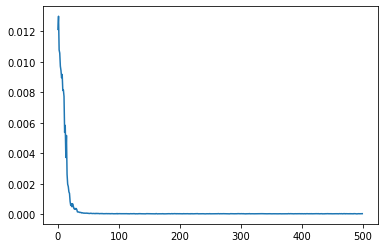

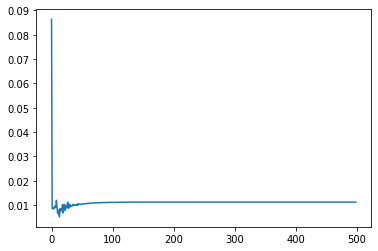

In [15]:
import matplotlib.pyplot as plt
plt.plot(total_l)
plt.show()

plt.plot(test_total_l)
plt.show()

In [4]:
import argparse
import progressbar

def evaluate(module):
    # loss function
    sun_crit = nn.KLDivLoss()

    # data loader
    eval_dataset = Eval_Dataset_SUN(csv_path='./mydata/trans_mode_label.csv')
    eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=4)
    print(eval_dataloader)

    module.eval()
    
    sum_err = np.asarray([0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    with progressbar.ProgressBar(max_value=data_length) as bar:
        for i, sample in enumerate(eval_dataloader):
            input_img = sample['img'].cuda().float()
            label_dis = sample['dis'].cuda().float()
            sunpos = sample['sp'][0].numpy()

            with torch.no_grad():
                #print("="*20,i,"="*20)
                pred_dis = module(input_img)
                #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
                #print("pred_dis : ", pred_dis)
                #print("pred_prrs : ", pred_prrs)
                #print(input_img)
                loss = sun_crit(pred_dis, label_dis)
                sum_loss += loss.item()
                
                # calculate all prediction error
                bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
                pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
                #print('pred_sunpos : ', pred_sunpos)
                suns.append(pred_sunpos)
                suns_gt.append(sunpos)
                sunpos_err = getAngle(sunpos, pred_sunpos)
                angular.append(sunpos_err)
                # Sky sun kappa beta turbidity
                sum_err += np.asarray([sunpos_err])
            bar.update(i)
    # print average prediction errors across all testing dataset
    print("="*20,"FINAL ERROR","="*20)
    print('Testing avg loss:', sum_loss/data_length)
    final_err = sum_err/data_length
    print('Average predictions error:')
    print('sun position (angular error):', final_err[0])
    return suns_gt, suns, bins, angular

In [5]:
def main(args):
    print('loading weights ...')
    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    module = IlluminationModule_SUN().cuda()
    #load pre-trained weight
    module.load_state_dict(torch.load(args.pre_trained))

    print('start evaluating ...')
    suns_gt, suns, bins, angular= evaluate(module)
    print('evaluation done!')
    return suns_gt, suns, bins, angular

In [6]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
  
    parser.add_argument('--pre_trained', default='./17_sun_weights.pth', help='pre-trained weight path')
    
    args = parser.parse_args(args=[])
    
    suns_gt, suns, bins, angular = main(args)

loading weights ...
start evaluating ...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100% (446 of 446) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


==================== FINAL ERROR ====================
Testing avg loss: 0.013262709206630682
Average predictions error:
sun position (angular error): 40.52660589599237
evaluation done!


In [9]:
print(angular)

[10.551246089860555, 6.309603943285302, 80.22603098231316, 16.23815695164246, 6.254499715017403, 93.69823530984766, 50.45964997945179, 0.44129225614633294, 116.79045329357733, 101.41181282907708, 0.9193430850922502, 123.85382212859174, 85.464586383137, 0.6397194580565669, 61.366123637474466, 60.25792811644792, 51.74136018756699, 62.47824946201191, 26.214796655304134, 13.913738425683032, 98.93962418238246, 105.3749753166864, 110.80303300125465, 100.63023160607479, 14.049394303836737, 2.4913614820074996, 12.620146089925553, 16.895571675091865, 52.53481131572869, 2.4913614820074996, 56.927972509332555, 11.798431417598097, 3.945330318728579, 111.61378469302853, 121.44285304339226, 1.768955336561102, 84.6405754111454, 17.705280766173946, 82.18686092533883, 84.72336754122081, 36.188076549558666, 28.236059175824394, 84.72336754122081, 8.523738789439676, 87.5343193006994, 28.814444146437417, 71.41288189237554, 10.421188560517496, 6.401983721767493, 70.85694104861439, 104.03265998108255, 97.364